In [2]:
import numpy as np
import matplotlib.pyplot as plt

from generate_chunks import load_data
from train_models import ModelTrainer
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
from itertools import combinations


In [52]:
# Load data and model
train_chunks, training_chunk_dates, test_chunks, test_chunk_dates = load_data()
channel_names = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs','Oil_temperature', 'Flowmeter', 'Motor_current']
model = ModelTrainer(f'configs/TCN_AE.json').fit()

(7, 1800, 8)
(7, 1800, 8)


<Figure size 640x480 with 0 Axes>

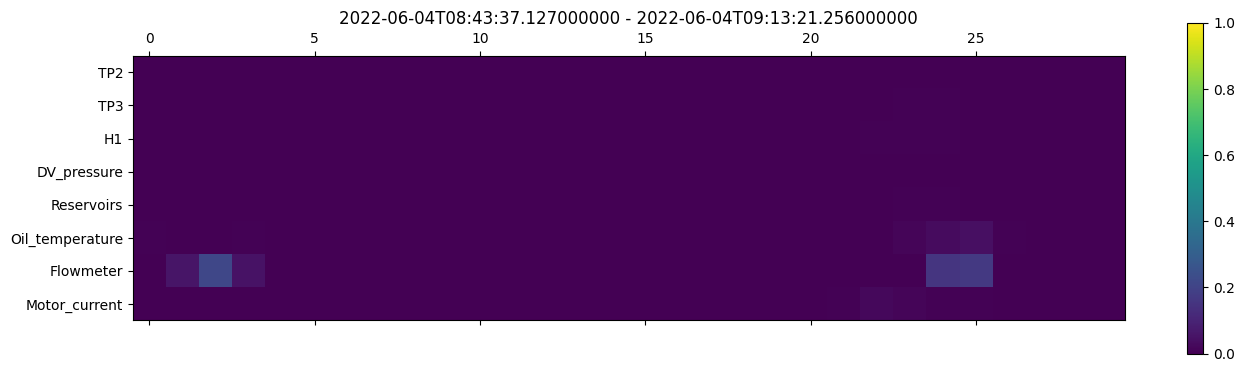

<Figure size 640x480 with 0 Axes>

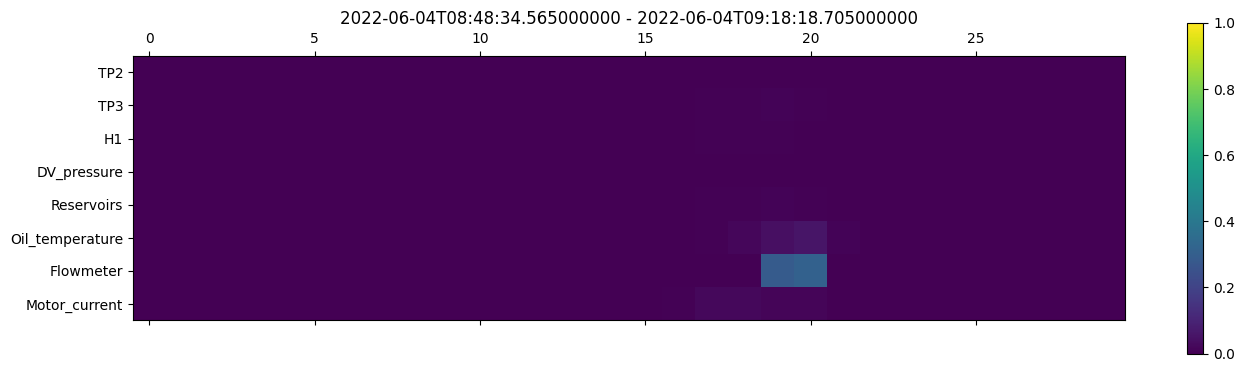

<Figure size 640x480 with 0 Axes>

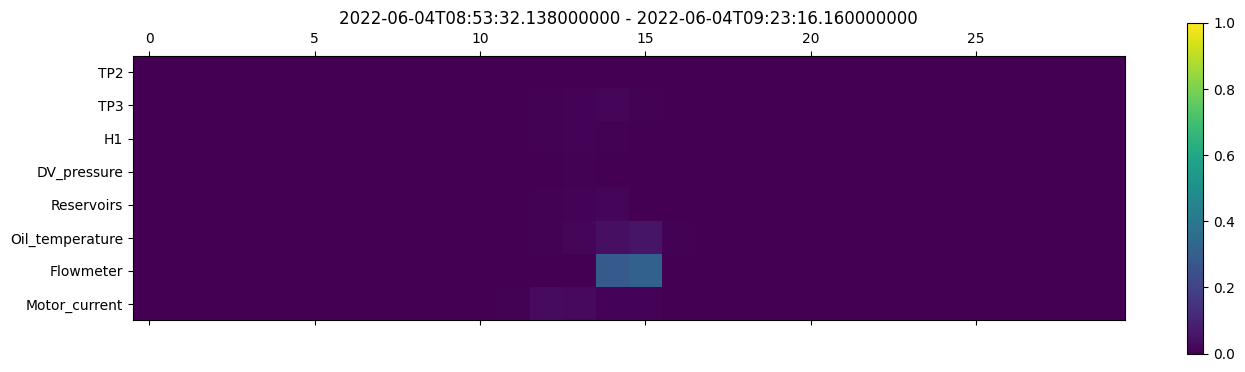

<Figure size 640x480 with 0 Axes>

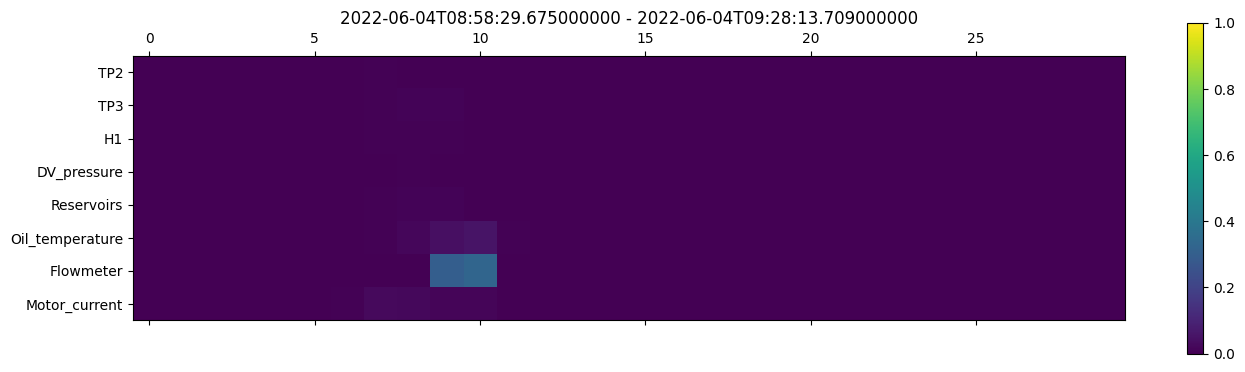

<Figure size 640x480 with 0 Axes>

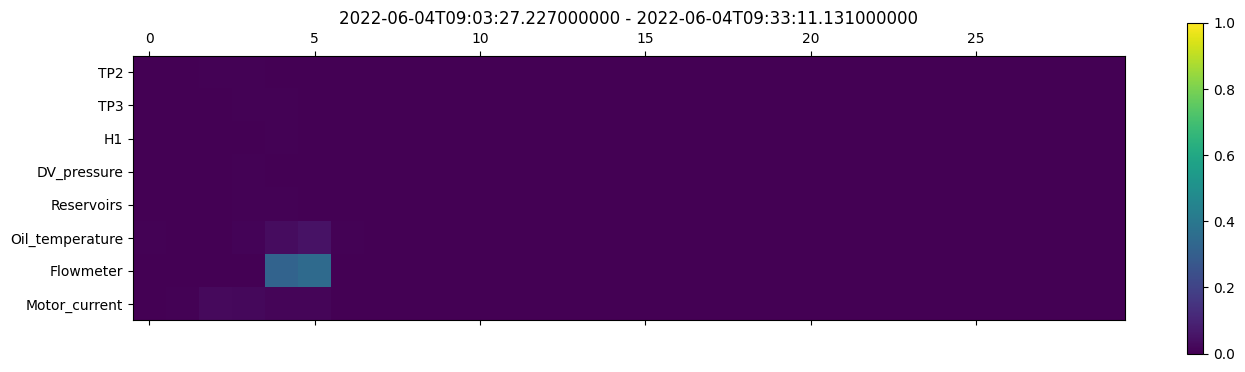

<Figure size 640x480 with 0 Axes>

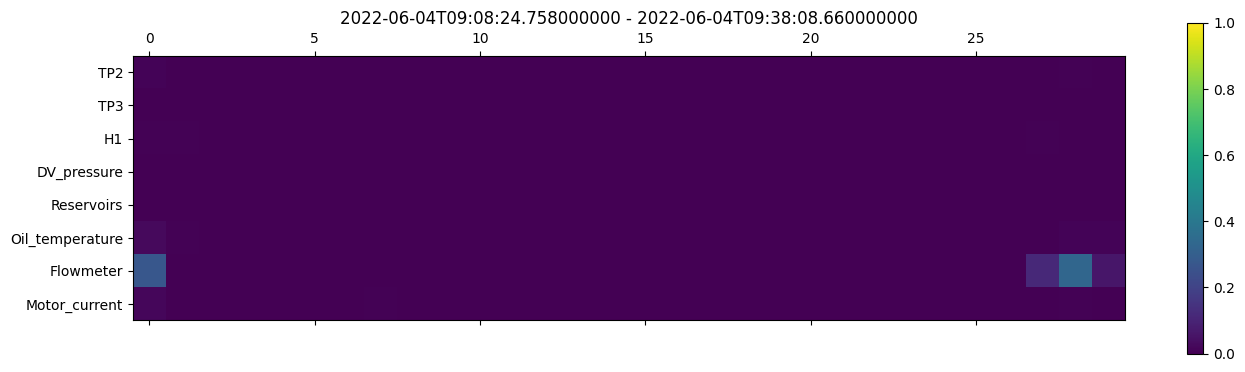

<Figure size 640x480 with 0 Axes>

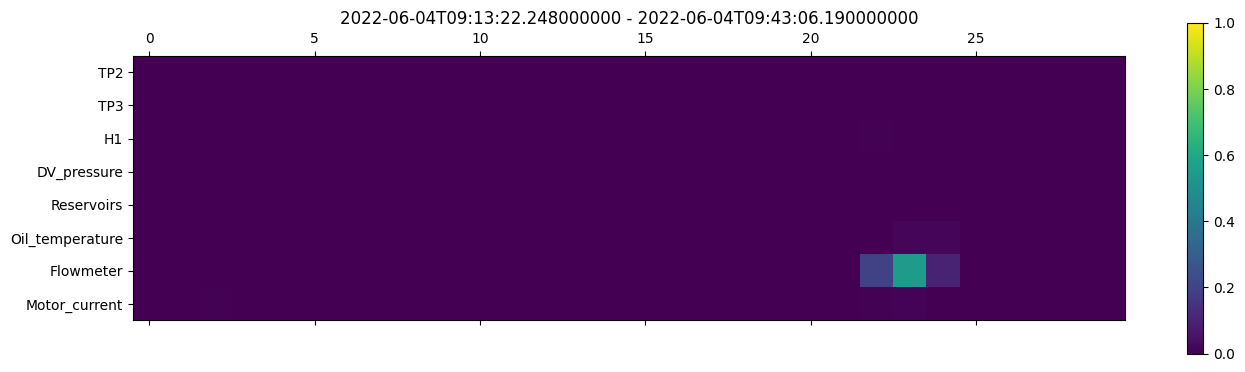

In [55]:
test_indices_to_check = np.array([899, 900, 901, 902, 903, 904, 905])
# Get prediction
X = test_chunks[test_indices_to_check]
reconstructions = model.predict(X)
errors = model.calc_loss(X, X, average=False)

segment_size = 60 # One minute segments
mask = np.arange(1800).reshape(-1, segment_size)
error_summary = errors[:, mask].sum(axis=2) / errors.sum(axis=(1, 2)).reshape(-1, 1, 1)

for i in range(len(test_indices_to_check)):
    index = test_indices_to_check[i]
    test_range = test_chunk_dates[index]
    plt.figure()
    plt.matshow(error_summary[i].T, vmin=0, vmax=1)
    plt.yticks(ticks=np.arange(len(channel_names)), labels=channel_names)
    plt.colorbar()
    plt.title(f'{test_range[0]} - {test_range[1]}')


<Figure size 640x480 with 0 Axes>

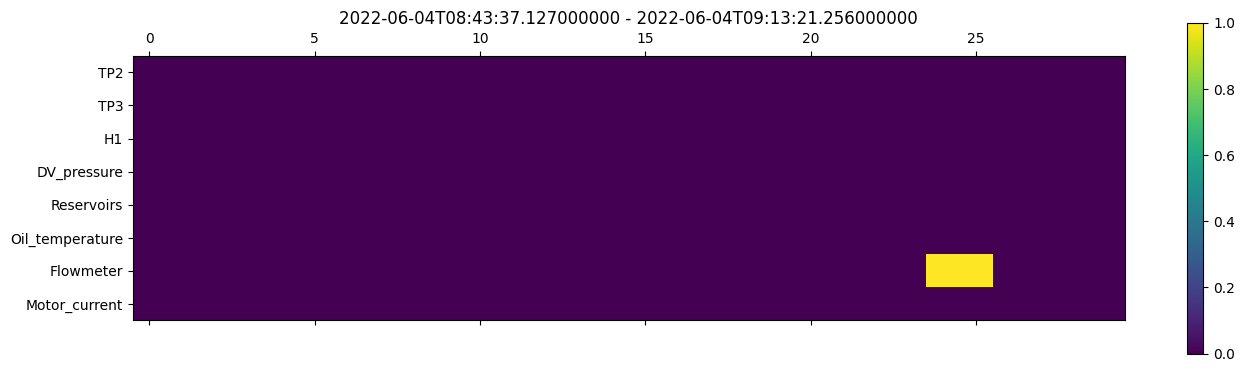

<Figure size 640x480 with 0 Axes>

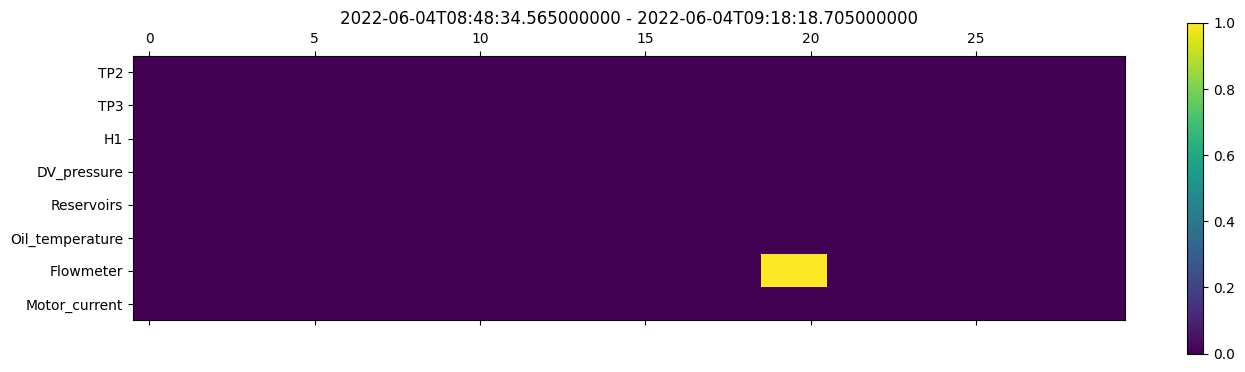

<Figure size 640x480 with 0 Axes>

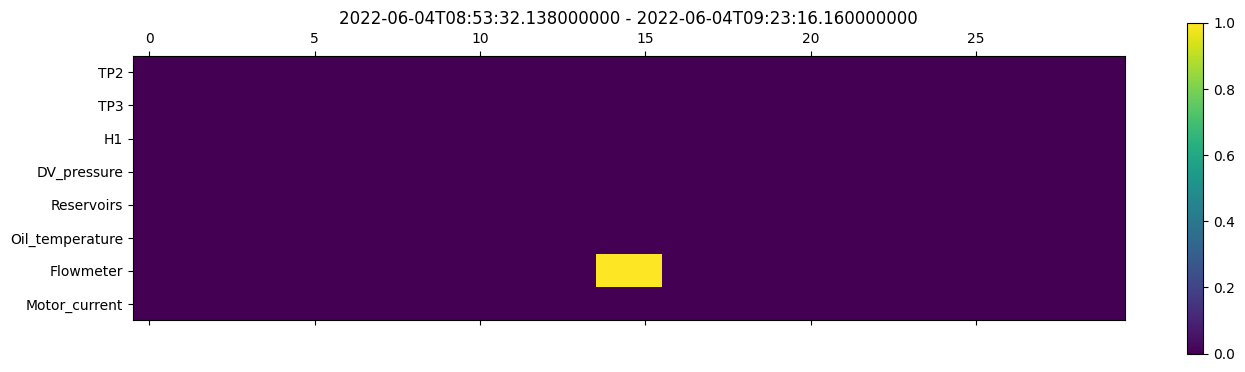

<Figure size 640x480 with 0 Axes>

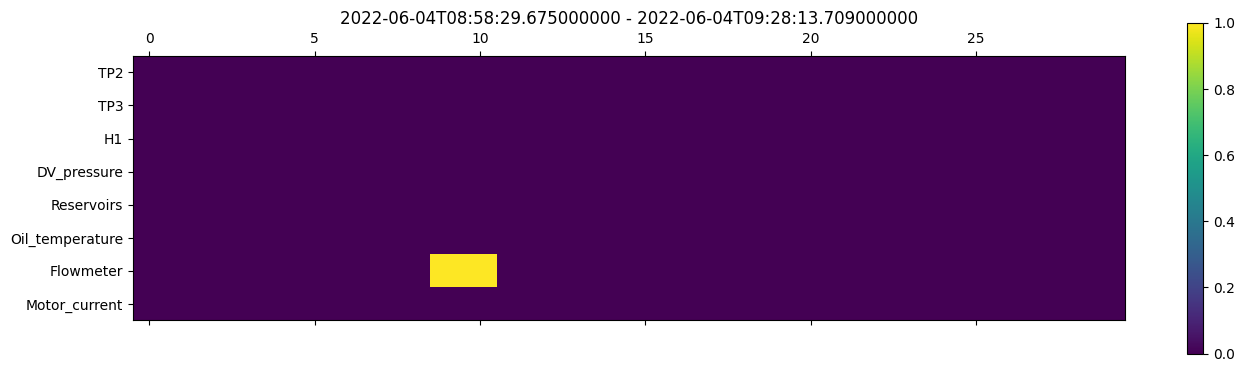

<Figure size 640x480 with 0 Axes>

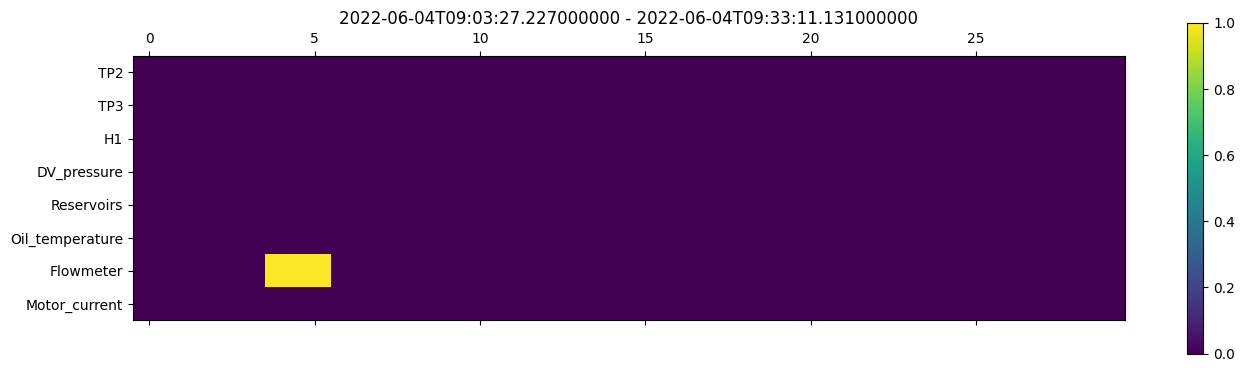

<Figure size 640x480 with 0 Axes>

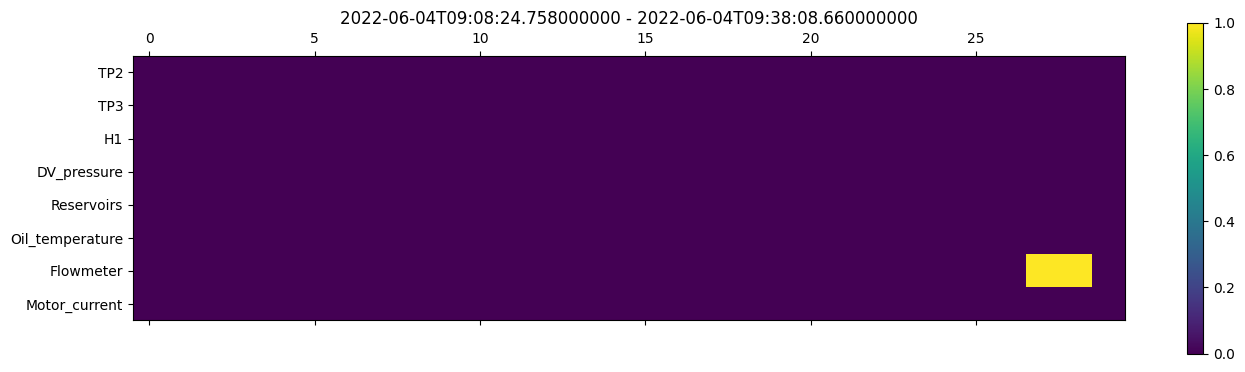

<Figure size 640x480 with 0 Axes>

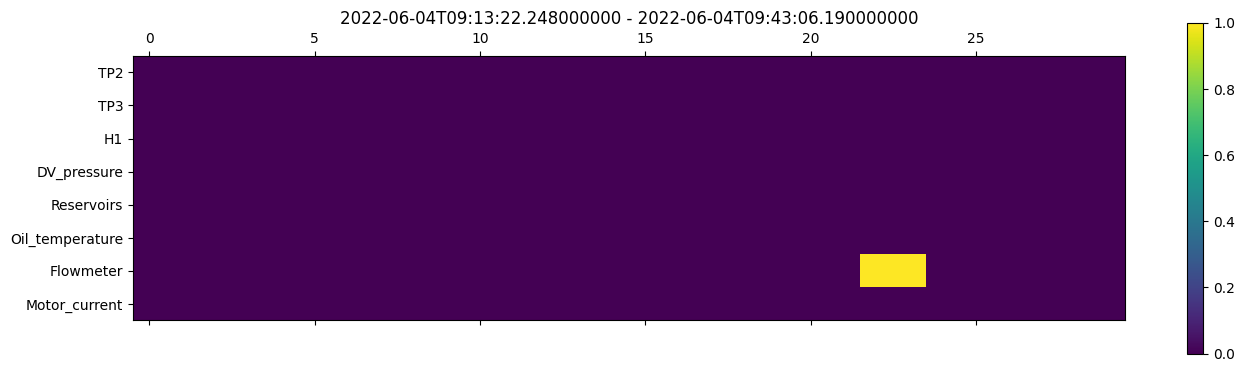

In [56]:
def find_connected_components(E, theta=None, return_2d=True):
    if theta is None:
        theta = E.max() * 0.1

    C = E.shape[0]
    T = E.shape[1]
    edges = np.zeros((T * C, T * C))

    for t in range(T):
        
        ## Connect if two channels are above threshold
        c = np.where(E[:, t] > theta)[0] * T + t
        
        for i1, i2 in combinations(c, 2):
            edges[i1, i2] = 1

        ## Connect if two consecutive timestamps are above threshold
        if t > 0:
            curr_slice = E[:, t] > theta
            prev_slice = E[:, t-1] > theta
            c = np.where(np.logical_and(curr_slice, prev_slice))[0] * T + t
            for _c in c:
                edges[_c, _c-1] = 1

    n_components, labels = connected_components(csr_matrix(edges), directed=False)
    components = []
    for i in range(n_components):
        elements = (labels == i).sum()
        if elements > 1:
            components.append(np.where(labels==i)[0])

    components_2d = []
    for component in components:
        y = component // T 
        x = component % T 
        components_2d.append(np.array(list(zip(x, y))))
    if return_2d:
        return components_2d
    return components

for i in range(len(test_indices_to_check)):
    index = test_indices_to_check[i]
    test_range = test_chunk_dates[index]
    E = error_summary[i].T
    components_2d = find_connected_components(E, theta=0.1)
    mask = np.zeros_like(E)
    for component in components_2d:
        mask[component[:, 1], component[:, 0]] = 1

    plt.figure()
    plt.matshow(mask, vmin=0, vmax=1)
    plt.yticks(ticks=np.arange(len(channel_names)), labels=channel_names)
    plt.colorbar()
    plt.title(f'{test_range[0]} - {test_range[1]}')

